In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn import preprocessing



In [2]:
# Importamos el dataset. Ayornen el path del archivo al que ustedes tengan. Así como el nombre del dataset.
# Como el dataset fue creado usando como delimitador un tab, si no lo definimos a la hora de importarlo, se va romper.
df = pd.read_csv('../dataset/reviews_yelp_nn.csv', sep='\t')

/anaconda3/envs/diplodatos/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.shape

(3342958, 9)

#### Análisis de la consistencia/inconsistencia de los datos

In [4]:
#veamos si existen reviews duplicadas en el dataset, para eso analizamos los ids de las reviews
df.review_id.duplicated().any()

True

Entonces tenemos elementos duplicados. A continuación analizamos primero si existen valores nulos:

In [5]:
df.review_id.isnull().any()

True

In [6]:
df.isnull().any()

business_id    False
cool            True
date            True
funny           True
review_id       True
stars           True
text            True
useful          True
user_id         True
dtype: bool

Eliminamos los valores nulos de nuestro dataset:

In [7]:
df_not_null = df.dropna()

Veamos ahora si seguimos teniendo valores duplicados en reviews_id:

In [8]:
df_not_null.review_id.duplicated().any()

False

Concluimos entonces que los valores duplicados de review_id provenían de la existencia de valores nulos, sigamos con el análisis.

En este procedimiento hemos eliminado valores nulos de nuestras features de interés, cool, stars, funny, useful. Tomamos esta decisión ya que no tenemos manera de inferir esos valores faltantes, además la cantidad de valores nulos presentes representa un porcentaje muy bajo con respecto a los valores no nulos, con lo cual eliminarlos no produce cambios significativos en el dataset.

Ilustramos este hecho a continuación:

In [9]:
valores_nulos = len(df.isnull().values[df.isnull().values == True])
total_valores = df.shape[0]
print("Porcentaje de valores nulos en el dataset: ", valores_nulos * 100 / total_valores)

Porcentaje de valores nulos en el dataset:  0.002183694799635532


### Descripción de las features

- "review_id": string, id de la review.

- "user_id": string, id para poder cruzar con otros dataset.

- "business_id": string, id para poder cruzar con otros dataset.

- "stars": int, el rating recibido.

- "date": fecha formateada como YYYY-MM-DD.

- "text": string, la review misma del lugar.

- "useful": int, número de votos "useful" recibidos.

- "funny": int, número de votos "funny" recibidos.

- "cool": int, número de votos "cool" recibidos.

Analicemos ahora los tipos de datos de las features para validar que los mismos no hayan cambiado luego de la importación:

In [10]:
df_not_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3342943 entries, 0 to 3342957
Data columns (total 9 columns):
business_id    object
cool           object
date           object
funny          float64
review_id      object
stars          float64
text           object
useful         float64
user_id        object
dtypes: float64(3), object(6)
memory usage: 255.0+ MB


Podemos notar que los tipos de las features **cool, funny, stars y useful** , cambiaron con respecto a la descripción de features expresada más arriba. Corregimos esto:

In [11]:
df_int = df_not_null[['stars', 'useful', 'funny', 'cool']]
df_int = df_int.astype(int)
df_int.dtypes

stars     int64
useful    int64
funny     int64
cool      int64
dtype: object

Ahora los features de interés tienen los tipos de datos esperados.

## Outliers: Valores extremos

Para ejemplificar esta situación usaremos la columna "useful", pero el análisis es análogo para el resto de las columnas de interés (salvo "stars" que no podría superar el 5 para ser un dato válido)

In [12]:
df_int["useful"].describe()["max"]

1122.0

Con un vistazo rápido a este feature, vemos que alcanza un máximo de 1122 votos. La pregunta acá es si esta cantidad de votos es lo suficientemente representativa para la columna o se trata de casos extremos o anómalos.

In [13]:
useful_ext = df_int[df_int["useful"] > 300 ]["useful"]
useful_ext.describe()


count      19.000000
mean      485.052632
std       206.649589
min       311.000000
25%       349.500000
50%       377.000000
75%       538.500000
max      1122.000000
Name: useful, dtype: float64

In [14]:
total_col = df_int["useful"].describe()["count"]
ext_val = useful_ext.describe()["count"]
prop = ext_val*100 / total_col
print("porcentaje de valores 'useful' mayores a 300: ", prop, "%")

porcentaje de valores 'useful' mayores a 300:  0.0005683614707160726 %


En las dos celdas anteriores observamos que en realidad una porción muy pequeña del dataset alcanza los 300 votos . Como la normalización de los datos funcionará mucho mejor que si nos deshacemos de algunos valores extremos, estas funciones se aplicarán sobre los sub-datasets respectivos a cada calificación de la review.

In [15]:
# Función de normalización de los datos
def normalize(data):
    x = data
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(data=x_scaled, columns=data.columns)


## Outliers: Valores imposibles

Podemos observar a continuación que si inspeccionamos la columna "cool", el mínimo en las estadísticas es el valor -1. Como ya sabemos que este feature representa la cantidad de calificaciones "cool" que recibió cada review, este número no tiene sentido: no podemos tener un cantidad negativa de votos.

In [17]:
df_int["cool"][df_int["cool"] < 0]

580769   -1
Name: cool, dtype: int64

# Variable USEFUL

In [38]:

trimmed = df_int["useful"] < 300

useful_norm = normalize(df_int[trimmed][["useful", "stars"]])
useful_norm = useful_norm[useful_norm["useful"] != 0.0]
useful_norm




/anaconda3/envs/diplodatos/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,useful,stars
0,0.003413,1.00
1,0.027304,1.00
2,0.003413,0.75
3,0.003413,1.00
4,0.013652,0.50
5,0.003413,0.75
6,0.006826,0.75
7,0.010239,1.00
8,0.003413,0.75
9,0.006826,0.25


### gráfico para USEFUL sin normalizar:

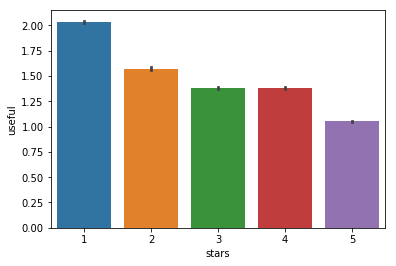

In [54]:
useful = df_int[trimmed][["useful", "stars"]]
sb.barplot(x=useful["stars"], y=useful["useful"])

### gráfico para USEFUL normalizado:

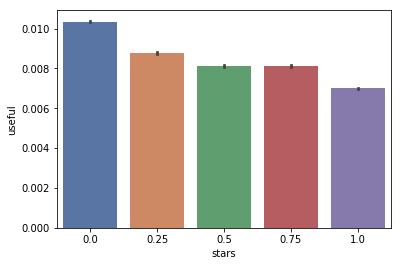

In [49]:
sb.barplot(x=useful_norm["stars"], y=useful_norm["useful"], palette="deep")

# Variable FUNNY

In [20]:
trimmed = df_int["funny"] < 200
funny_norm = normalize(df_int[trimmed][["funny", "stars"]])
funny_norm = funny_norm[funny_norm["funny"] != 0.0]
funny_norm.head()

/anaconda3/envs/diplodatos/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,funny,stars
1,0.010526,1.00
5,0.010526,0.75
10,0.005263,0.50
12,0.005263,0.50
17,0.005263,1.00


### gráfico para USEFUL sin normalizar:

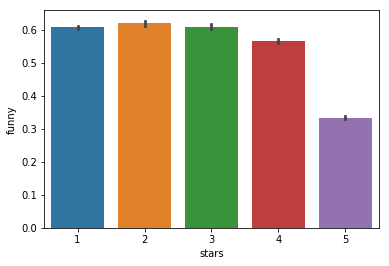

In [57]:
funny = df_int[trimmed][["funny", "stars"]]
sb.barplot(x=funny["stars"], y=funny["funny"])

### gráfico para USEFUL normalizado:

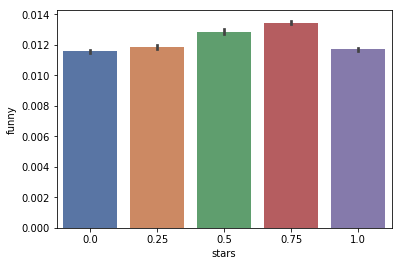

In [50]:
sb.barplot(x=funny_norm["stars"], y=funny_norm["funny"], palette="deep")

# COOL

In [23]:
trimmed = df_int["cool"] < 200
cool_norm = normalize(df_int[trimmed][["cool", "stars"]])
cool_norm = cool_norm[cool_norm["cool"] != 0.0]
cool_norm.head()

/anaconda3/envs/diplodatos/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,cool,stars
0,0.005,1.00
1,0.030,1.00
2,0.005,0.75
3,0.005,1.00
4,0.010,0.50


### gráfico para USEFUL sin normalizar:

In [ ]:
cool = df_int[trimmed][["cool", "stars"]]
sb.barplot(x=cool["stars"], y=cool["cool"])

### gráfico para USEFUL normalizado:

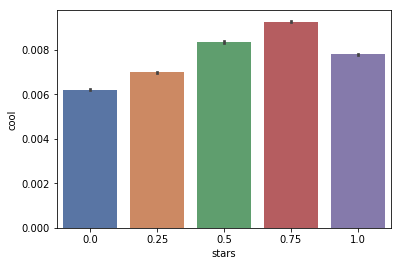

In [51]:
sb.barplot(x=cool_norm["stars"], y=cool_norm["cool"], palette="deep")